In [160]:

import sys

import torch

torch.set_default_dtype(torch.float64)

sys.path.append('../Packages')
sys.path.append('../Scripts')
from torch.utils.data import DataLoader, Dataset
from skimage import filters
from tqdm.notebook import tqdm as tqdm
from Scripts.model import *
from Scripts.plot import *
import os
import Packages.algo.geodesic as geo
import Packages.algo.euler as euler

from Packages.disp.vis import *
from Packages.util import riemann, tensors
from pathlib import Path
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
    
%matplotlib widget

/home/pits/Documents/MVA/geometric_data_analysis/Metric-Cnn-2D-IPM/Packages/disp/vis.py:8: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if hasattr(np, 'bool'):


In [161]:
mode = 'cpu'
device = torch.device('cpu')
torch.set_default_dtype(torch.float64)

In [104]:
base_path = Path('../Data/100610')

In [105]:
def get_v_path(number, base_path):
    return base_path / f'dyads{number}.nii.gz'
def get_f_path(number, base_path):
    return base_path / f'mean_f{number}samples.nii.gz'

In [106]:
vector_imgs = [nib.load(get_v_path(i+1, base_path)).get_fdata() for i in range(3)]
fraction_imgs = [nib.load(get_f_path(i+1, base_path)).get_fdata() for i in range(3)]

In [248]:
def plot_slice(z_slice, fibers, mask_threshold):
    """
    Affiche la slice z_slice.
    fibers: liste des fibres à afficher, ex: [1] ou [1, 2]
    """

    slice_x, slice_y = slice(55, 90), slice(100, 160)

    plt.figure(figsize=(6, 6), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('black')

    dims = fraction_imgs[0][slice_x, slice_y, z_slice].shape
    x_grid, y_grid = np.meshgrid(np.arange(dims[0]), np.arange(dims[1]), indexing='ij')

    colors = {1: 'red', 2: 'cyan', 3: 'yellow'}

    for fib_idx in fibers:
        if fib_idx > len(vector_imgs): continue 

        vec_data = vector_imgs[fib_idx - 1][slice_x, slice_y, z_slice, :]
        current_mask = fraction_imgs[fib_idx - 1][slice_x, slice_y, z_slice] > mask_threshold
        
        plt.quiver(x_grid[current_mask], y_grid[current_mask],
                   vec_data[current_mask, 0], vec_data[current_mask, 1],
                   color=colors.get(fib_idx, 'white'),
                   scale=30, headwidth=0, headlength=0, width=0.005, alpha=0.9,
                   label=f'Fibre {fib_idx}')

    plt.title(f"Slice Z={z_slice} | Fibres {fibers}", color='white')

    plt.legend(loc='upper right', fontsize='small')
    plt.axis('off')
    plt.show()

In [249]:
interact(
    plot_slice,
    z_slice=widgets.IntSlider(min=0, max=img_v1.shape[2]-1, step=1, value=img_v1.shape[2]//2, continuous_update=False),
    mask_threshold=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1, continuous_update=False),    
    fibers=widgets.SelectMultiple(options=[1, 2, 3], value=[1], description='fibers:'),
)

interactive(children=(IntSlider(value=72, continuous_update=False, description='z_slice', max=144), SelectMult…

<function __main__.plot_slice(z_slice, fibers, mask_threshold)>

In [250]:
z_slice = 72
mask_threshold = 0.25
slice_x, slice_y = slice(55, 90), slice(100, 160)

In [251]:
brain_vector_field = vector_imgs[0][slice_x, slice_y, z_slice, :-1]
brain_mask = fraction_imgs[0][slice_x, slice_y, z_slice] > mask_threshold
height, width = brain_mask.shape

In [252]:
brain_vector_field.shape

(35, 60, 2)

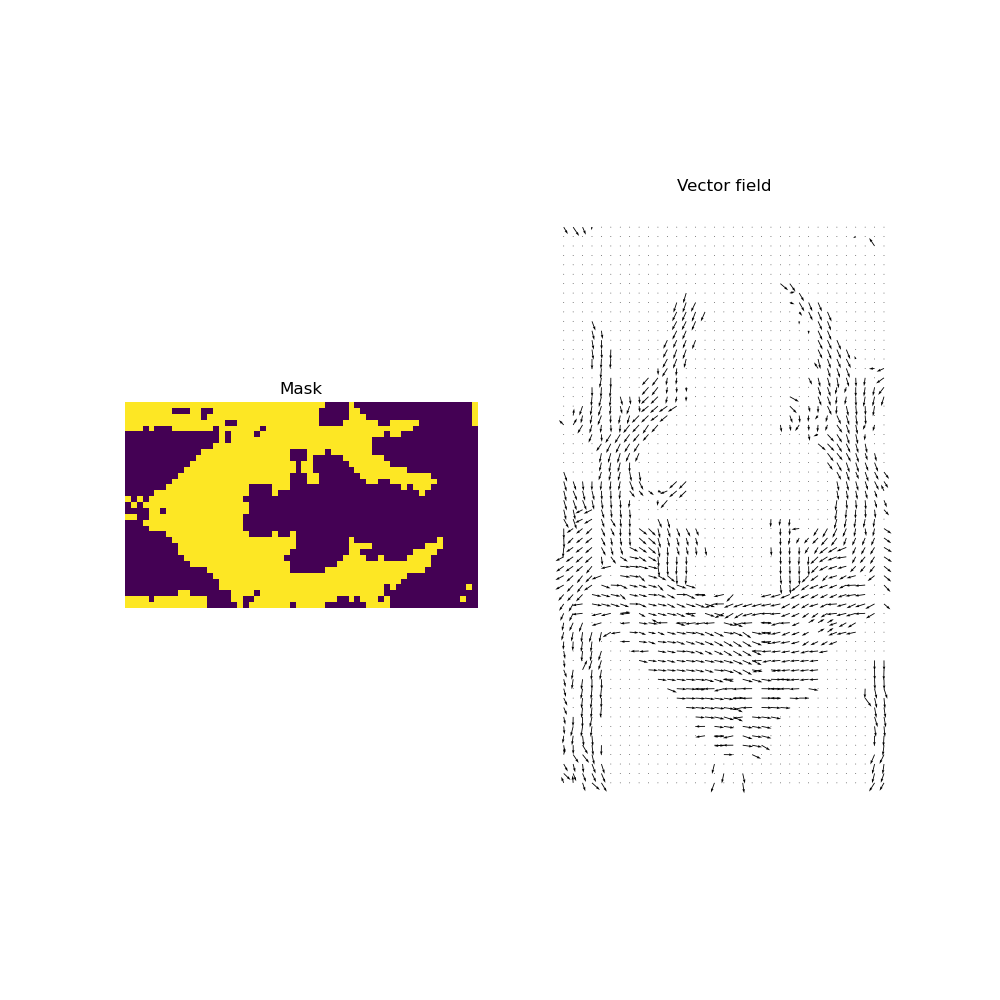

In [253]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

xx, yy = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

for ax in axs.ravel():
    ax.set_axis_off()
    ax.set_aspect('equal', adjustable='box')

axs[0].imshow(brain_mask)
axs[0].set_title(f'Mask')
axs[1].quiver(
    xx,
    yy,
    brain_vector_field[:, :, 0]*brain_mask,
    brain_vector_field[:, :, 1]*brain_mask
)
axs[1].set_title(f'Vector field')

plt.show()

In [254]:
class ImageDataset(Dataset):
    def __init__(self, vector_field, mask):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.sample = {
            'vector_field':vector_field.permute(2, 0, 1).to(device).float() * 1000.0,
            'mask': mask.permute(1, 0).float().to(device).unsqueeze(0)
        }

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.sample


def matrix_exp_2d(A):
    """
    Construct positive definite matrix from symmetric matrix field A
    Args:
        A, torch.Tensor
    Returns:
        psd, torch.Tensor
    """
    I = torch.zeros_like(A, device='cpu')
    I[..., 0, 0] = 1
    I[..., 1, 1] = 1

    s = ((A[..., 0, 0] + A[..., 1, 1]) / 2.).unsqueeze(-1).unsqueeze(-1)
    q = torch.sqrt(-torch.det(A - torch.mul(s, I))).unsqueeze(-1).unsqueeze(-1)

    psd = torch.exp(s) * (torch.mul((torch.cosh(q) - s * torch.sinh(q) / q), I) + torch.sinh(q) / q * A)
    return psd


def pde(u, vector_lin, mask, differential_accuracy=2):
    s = tensors.lin2mat(u)
    metric_mat = matrix_exp_2d(s)
    nabla_vv = riemann.covariant_derivative_2d(vector_lin, metric_mat, mask, differential_accuracy=differential_accuracy)

    return nabla_vv

In [264]:
def make_square(vector_field, mask):
    """
    Rend les tableaux carrés en ajoutant du padding (zéros)
    autour de la dimension la plus petite pour centrer l'image.
    """
    h, w = mask.shape
    target_size = max(h, w)
    target_size += (4-target_size)%4
    
    # Calcul du padding nécessaire (total)
    pad_h = target_size - h
    pad_w = target_size - w
    
    # Répartition du padding (Haut/Bas et Gauche/Droite)
    # On utilise // 2 pour centrer l'image
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    
    # 1. Padding du Mask (2D : Height, Width)
    # mode='constant', constant_values=0 ajoute des False (0) autour
    square_mask = np.pad(mask, 
                         ((pad_top, pad_bottom), (pad_left, pad_right)), 
                         mode='constant', constant_values=0)
    
    # 2. Padding du Champ de Vecteur (3D : Height, Width, Channels)
    # Attention : on ne veut PAS ajouter de padding sur la 3ème dimension (les composantes x,y)
    # Donc on met (0, 0) pour la dernière dimension
    square_vectors = np.pad(vector_field, 
                            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), 
                            mode='constant', constant_values=0)
    
    return square_vectors, square_mask

In [265]:
sq_vectors, sq_mask = make_square(brain_vector_field, brain_mask)
sq_vectors = torch.from_numpy(sq_vectors).to(device).double()
sq_mask = torch.from_numpy(sq_mask).to(device).double()
im_size = sq_mask.shape[0]

In [266]:
sq_mask.shape, sq_vectors.shape

(torch.Size([60, 60]), torch.Size([60, 60, 2]))

In [317]:
epoch_loss_list = []
epoch_num = 15000
start_epoch_num = 0
learning_rate = 1e-4

model = DenseED(
    in_channels=2,
    out_channels=3,
    imsize=im_size,
    blocks=[6, 8, 6],
    growth_rate=16,
    init_features=48,
    drop_rate=0,
    out_activation=None,
    upsample='nearest'
)
model.train()

criterion = torch.nn.MSELoss()
optimizer_id = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

dataset_id = ImageDataset(sq_vectors, sq_mask)

dataloader_id = DataLoader(dataset_id, batch_size=1, shuffle=True, num_workers=0)

# params 742443, # conv layers 28


In [318]:
model = model.float()
for epoch in tqdm(range(start_epoch_num, start_epoch_num + epoch_num)):
    epoch_loss_id = 0

    for i, batched_id_sample in enumerate(dataloader_id):
        '''innerdomain backpropagate'''
        input_id = batched_id_sample['vector_field'].to(device).float()
        input_id.requires_grad = True
        # u_pred_id: [batch_size, *data_shape, feature_num] = [1, 3, ...]
        u_pred_id = model(input_id)
        # f_pred_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        mask = batched_id_sample['mask'].squeeze()

        pde_loss = pde(u_pred_id.squeeze().double(), 
                       input_id[0, :].double(),  # <-- On utilise la version 176x176
                       mask.double(),    # <-- On utilise le masque 176x176
                       differential_accuracy=2)

        # 4. Calcul de f_preds (Attention aux dimensions)
        # pde_loss est maintenant en 176x176. mask_padded aussi.
        f_preds = torch.einsum('...ij,...ij->...ij', pde_loss, mask.unsqueeze(0).expand(2, -1, -1))

        f_pred_id = torch.cat([f_preds], 0) # [2, 176, 176] ou [2, 174, 174] selon crop
        
        f_true_id = torch.zeros_like(f_pred_id)

        optimizer_id.zero_grad()
        loss_id = criterion(f_pred_id, f_true_id)
        loss_id.backward()
        epoch_loss_id += loss_id.item()
        optimizer_id.step()


    epoch_loss_list.append(epoch_loss_id)
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_id_state_dict': optimizer_id.state_dict(),
            'loss_id': epoch_loss_id
        }, 'models/model_tmp.pth.tar')

  0%|          | 0/15000 [00:00<?, ?it/s]

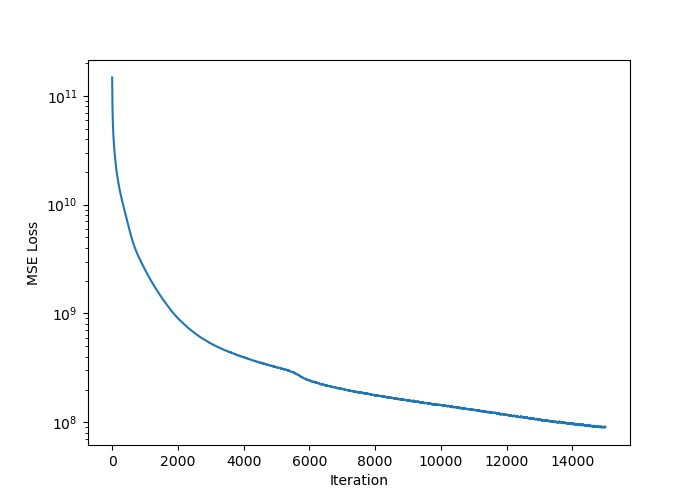

In [319]:
_, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE Loss')
ax.set_yscale('log')
ax.plot(epoch_loss_list)

In [320]:
checkpoint = torch.load(f'models/model_tmp.pth.tar')

model.load_state_dict(checkpoint['model_state_dict'])

mask = torch.where(sq_mask > 0, 1, 0)
model = model.float()
u_pred = model(sq_vectors.permute(2, 0, 1).unsqueeze(0).float())
u_pred = u_pred.squeeze()
s_pred = tensors.lin2mat(u_pred)

metric_pred_mat = matrix_exp_2d(s_pred)
metric_pred_lin = tensors.mat2lin(metric_pred_mat)

In [321]:
vector_lin = sq_vectors.permute(2, 0, 1).numpy()
tensor_pred_mat = np.linalg.inv(metric_pred_mat.detach().numpy())
tensor_pred_lin = tensors.mat2lin(tensor_pred_mat)

In [322]:
geo_delta_t, euler_delta_t = 5e-3, 5e-3
geo_iters, euler_iters = int(1e6), int(1e6)

In [323]:
start_coord = np.array([30, 10])

In [324]:

eulx, euly, geox_pred, geoy_pred = (
    # EULER : Utilise tout en version PADDÉE (Vecteur 176, Masque 176)
    euler.eulerpath_vectbase_2d_w_dv(
        vector_lin,    
        mask,          
        start_coord,   
        euler_delta_t, 
        iter_num=euler_iters,
        both_directions=True
    )
    # GEODESIC : C'est ici l'astuce !
    # - Tenseur : ORIGINAL (174) -> Génère Gamma (176)
    # - Vecteur : PADDÉ (176) -> Matche Gamma (176)
    # - Masque : ORIGINAL (174) -> Pour le calcul de Gamma
    + geo.geodesicpath(
        'f', 
        tensor_pred_lin,     # <--- ATTENTION : On utilise l'Original (174)
        vector_lin,      # <--- On utilise le Paddé (176)
        mask,                # <--- On utilise l'Original (174) pour consistency avec Tenseur
        start_coord,     # <--- Coordonnée décalée
        # Vélocité initiale : On la lit sur le vecteur PADDÉ aux coords DÉCALÉES
        vector_lin[:, start_coord[0], start_coord[1]], 
        geo_delta_t, 
        iter_num=geo_iters,
        both_directions=True
    )
)

Euler starting eigenvector: [0.99556929 0.03221538]
Euler starting eigenvector: [-0.99556929 -0.03221538]
Shooting geodesic path from [30 10] with initial velocity [0.99556929 0.03221538]
Shooting geodesic path from [30 10] with initial velocity [-0.99556929 -0.03221538]


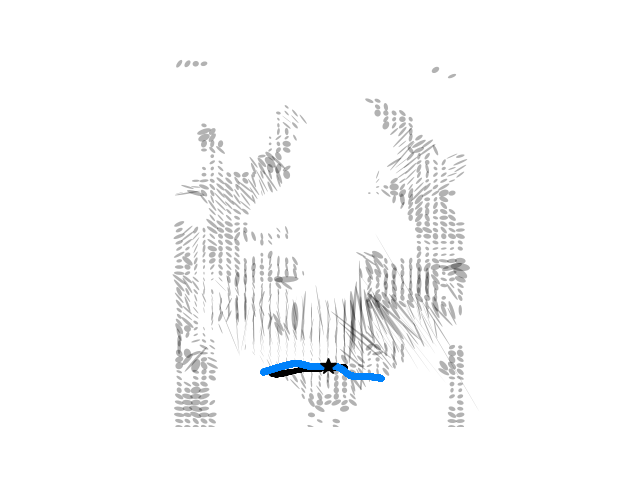

In [325]:

def disp_path(ax, x, y, label, color, size, alpha):
    ax.scatter(x[::1], y[::1], c=color, s=size, alpha=alpha, label=label, zorder=1)


fig, ax = plt.subplots()
tens_fig = vis_tensors(metric_pred_lin.cpu().detach().numpy() * np.stack((sq_mask, sq_mask, sq_mask), 0), '', False, scale=8e-1,
                       opacity=0.3, show_axis_labels=False, ax=ax)
disp_path(ax, eulx, euly, label="integral curve on vector field", color='black', size=2, alpha=1)

disp_path(ax, geox_pred, geoy_pred, label=f"geodesic on learned", color='#0082fb', size=10, alpha=1)

ax.plot(start_coord[0], start_coord[1], linestyle='', marker='*', color='black', markersize=12)